# Station Location Map Plots

In [1]:
import requests
import pandas as pd
import fiona
import pyproj
import rasterio
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os

matplotlib.rc('pdf', fonttype=42)

plt.style.use("/home/mchristo/proj/libmsc/style/msc.mplstyle")

## Make contours and hillshade from DEM

In [3]:
# Make contours
!gdal_contour -a elev ./data/topo/augustine_ifsar.tif ./data/topo/augustine_ifsar_contour.gpkg -i 100 -off 20
!gdal_contour -a elev ./data/topo/ross_pgc.tif ./data/topo/ross_pgc_contour.gpkg -i 100 -off 5


# Make hillshades
!gdaldem hillshade ./data/topo/augustine_ifsar.tif ./data/topo/augustine_ifsar_hillshade.tif
!gdaldem hillshade ./data/topo/ross_pgc.tif ./data/topo/ross_pgc_hillshade.tif

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


## Load station locations, hillshades, contours, borders

In [4]:
# url to get station locations
# Built here:
# https://service.iris.edu/fdsnws/station/docs/1/builder/
url_aug = "https://service.iris.edu/fdsnws/station/1/query?net=AV&sta=AU11,AU12,AU13,AU14&cha=HHE&starttime=2005-11-01&endtime=2006-05-01&level=station&format=text&includecomments=true&nodata=404"
df_aug = pd.read_csv(url_aug, sep="|")
xform = pyproj.Transformer.from_crs("4326", "3338")
df_aug["x"], df_aug["y"] = xform.transform(df_aug[" Latitude "], df_aug[" Longitude "])

url_ereb = "https://service.iris.edu/fdsnws/station/1/query?net=ER&sta=NKB,E1S&cha=BHZ&starttime=2003-01-01&endtime=2013-01-01&level=station&format=text&includecomments=true&nodata=404"
df_ereb = pd.read_csv(url_ereb, sep="|")
xform = pyproj.Transformer.from_crs("4326", "3031")
df_ereb["x"], df_ereb["y"] = xform.transform(df_ereb[" Latitude "], df_ereb[" Longitude "])

In [5]:
with rasterio.open("./data/topo/augustine_ifsar_hillshade.tif", "r") as src:
    left_aug, bottom_aug, right_aug, top_aug = src.bounds
    hillshade_aug = src.read(1)

with rasterio.open("./data/topo/augustine_ifsar.tif", "r") as src:
    hgt_aug = src.read(1)

with rasterio.open("./data/topo/ross_pgc_hillshade.tif", "r") as src:
    left_ereb, bottom_ereb, right_ereb, top_ereb = src.bounds
    hillshade_ereb = src.read(1)

In [6]:
aug_contours = []
with fiona.open("./data/topo/augustine_ifsar_contour.gpkg") as fd:
    for line in fd:
        aug_contours.append(list(zip(*line['geometry']['coordinates'])))

ereb_contours = []
with fiona.open("./data/topo/ross_pgc_contour.gpkg") as fd:
    for line in fd:
        ereb_contours.append(list(zip(*line['geometry']['coordinates'])))

In [9]:
alaska_border = []
with fiona.open("./data/alaska_border.gpkg") as fd:
    for line in fd:
        alaska_border.append(list(zip(*line['geometry']['coordinates'])))
alaska_border = list(alaska_border[0][0])

with fiona.open("./data/canada_border.gpkg") as fd:
    for state in fd:
        for poly in state['geometry']['coordinates']:
            alaska_border.append(poly[0])

In [11]:
antarc_border = []
with fiona.open("./data/antarctica_border.gpkg") as fd:
    for poly in fd:
        if(poly.properties["surface"] != "land"):
            continue
        antarc_border.append(poly['geometry']['coordinates'][0][0])

In [12]:
with fiona.open("./data/erebus/lowvel.gpkg") as fd:
    for poly in fd:
        lowvel = poly['geometry']['coordinates'][0]

## Make figure

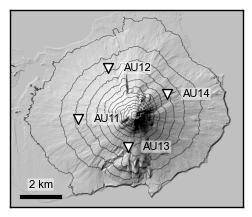

In [14]:
fig = plt.figure(figsize=(3, 3))
ax = fig.gca()

## Augustine ##
ax.grid(False)

# Hillshade
ax.imshow(
    hillshade_aug,
    cmap="Greys_r",
    extent=[left_aug, right_aug, bottom_aug, top_aug],
    vmin=50,
    vmax=255,
    zorder=0
)
ax.set(xlim = (left_aug+12e3, right_aug-5e3), ylim = (bottom_aug+8e3, top_aug-10.5e3), xticks=[], yticks=[])
#ax_aug.set(xlim = (left_aug+14e3, right_aug-7e3), ylim = (bottom_aug+10e3, top_aug-12.5e3), xticks=[], yticks=[])
ax.set_aspect("equal")

# Contours
for contour in aug_contours:
    ax.plot(contour[0], contour[1], 'k-', alpha=0.5, linewidth=0.5)

# Stations
ax.scatter(
    df_aug["x"],
    df_aug["y"],
    marker="v",
    s=50,
    edgecolor="k",
    facecolor="w",
    zorder=2
)


for i, row in df_aug.iterrows():
    ax.text(row["x"]+1500, row["y"]-1e-4, row[" Station "].strip(),
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=8,
            zorder=4,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1', alpha=0.5)
    )
    
# Scale bar
axmin, axmax = ax.get_xlim()
aymin, aymax = ax.get_ylim()
bly_aug = aymin + (0.05*(aymax-aymin))
blx_aug = axmin + (0.05*(axmax-axmin))

ax.plot([blx_aug, blx_aug+2e3], [bly_aug, bly_aug], linewidth=3)

ax.text(
    blx_aug+1e3,
    bly_aug+400,
    "2 km",
    fontsize=8,
    horizontalalignment="center",
    verticalalignment="bottom",
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1', alpha=0.5)
)

# Augustine aspect ratio for erebus plot
aspect = (axmax-axmin)/(aymax-aymin)

#fig.savefig("figs/augustine_station_map.pdf", bbox_inches="tight")

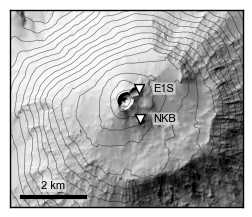

In [15]:
fig = plt.figure(figsize=(3, 3))
ax = fig.gca()

## Erebus ##
ax.grid(False)

# Hillshade
ax.imshow(
    hillshade_ereb,
    cmap="Greys_r",
    extent=[left_ereb, right_ereb, bottom_ereb, top_ereb],
    vmin=50,
    vmax=255,
    zorder=0
)
ax.set_xlim(left_ereb+2e3, right_ereb-2e3)
exmin, exmax = ax.get_xlim()
yclip = (top_ereb-bottom_ereb) - ((exmax-exmin)/aspect)
ax.set(ylim = (bottom_ereb+yclip/2 + 1e3, top_ereb-yclip/2 + 1e3), xticks=[], yticks=[])
ax.set_aspect("equal")

# Contours
for contour in ereb_contours:
    ax.plot(contour[0], contour[1], 'k-', alpha=0.5, linewidth=.5)

# Stations
ax.scatter(
    df_ereb["x"],
    df_ereb["y"],
    marker="v",
    s=50,
    edgecolor="k",
    facecolor="w",
    zorder=2
)


for i, row in df_ereb.iterrows():
    ax.text(row["x"]+800, row["y"]-1e-4, row[" Station "].strip(),
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=8,
            zorder=4,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1', alpha=0.5)
    )

# Scale bar
exmin, exmax = ax.get_xlim()
eymin, eymax = ax.get_ylim()
bly_ereb = eymin + (0.05*(eymax-eymin))
blx_ereb = exmin + (0.05*(exmax-exmin))

ax.plot([blx_ereb, blx_ereb+2e3], [bly_ereb, bly_ereb], linewidth=3)

ax.text(
    blx_ereb+1e3,
    bly_ereb+200,
    "2 km",
    fontsize=8,
    horizontalalignment="center",
    verticalalignment="bottom",
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1', alpha=0.5)
)

#fig.savefig("figs/erebus_station_map.pdf", bbox_inches="tight")

## Single figure two subplots

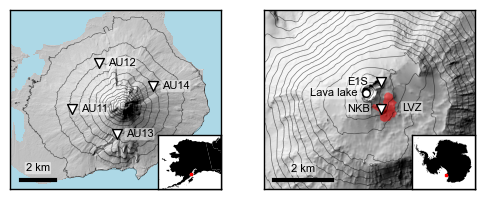

In [17]:
# Single figure with two subplots
fig, (ax_aug, ax_ereb) = plt.subplots(1, 2, figsize=(6, 3))


## Augustine ##
ax_aug.grid(False)
ax_aug.set_facecolor("lightblue")

hillshade_aug = hillshade_aug.astype(np.float32)
hillshade_aug[hgt_aug == 0] = np.nan
# Hillshade
ax_aug.imshow(
    hillshade_aug,
    cmap="Greys_r",
    extent=[left_aug, right_aug, bottom_aug, top_aug],
    vmin=50,
    vmax=255,
    zorder=0
)
ax_aug.set(xlim = (left_aug+12e3, right_aug-5e3), ylim = (bottom_aug+8e3, top_aug-10.5e3), xticks=[], yticks=[])
#ax_aug.set(xlim = (left_aug+14e3, right_aug-7e3), ylim = (bottom_aug+10e3, top_aug-12.5e3), xticks=[], yticks=[])
ax_aug.set_aspect("equal")

# Contours
for contour in aug_contours:
    ax_aug.plot(contour[0], contour[1], 'k-', alpha=0.5, linewidth=0.5)

# Stations
ax_aug.scatter(
    df_aug["x"],
    df_aug["y"],
    marker="v",
    s=50,
    edgecolor="k",
    facecolor="w",
    zorder=2
)


for i, row in df_aug.iterrows():
    ax_aug.text(row["x"]+1300, row["y"]-1e-4, row[" Station "].strip(),
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=8,
            zorder=4,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1', alpha=0.5)
    )
    
# Scale bar
axmin, axmax = ax_aug.get_xlim()
aymin, aymax = ax_aug.get_ylim()
bly_aug = aymin + (0.05*(aymax-aymin))
blx_aug = axmin + (0.05*(axmax-axmin))

ax_aug.plot([blx_aug, blx_aug+2e3], [bly_aug, bly_aug], linewidth=3)

ax_aug.text(
    blx_aug+1e3,
    bly_aug+400,
    "2 km",
    fontsize=8,
    horizontalalignment="center",
    verticalalignment="bottom",
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1', alpha=0.5)
)

# Add label
alabel = ax_aug.annotate(
    "a",
    (.025,.925),
    xycoords="axes fraction",
    fontsize=8,
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1', alpha=0.5)
)
# Augustine aspect ratio for erebus plot
aspect = (axmax-axmin)/(aymax-aymin)

# Alaska inset map
axins = inset_axes(ax_aug, width="30%", height="30%", loc=4, borderpad=0)
#axins.set_aspect(1)
axins.set_facecolor("white")
axins.grid(False)
axins.tick_params(axis="both", bottom=False, labelbottom=False, left=False, labelleft=False, right=False, top=False)
for border in alaska_border:
    bx, by = zip(*border)
    axins.fill(bx, by, "k-", linewidth=0.5)

axins.plot([30181], [1042301], "rs", markersize=2)
axins.set_xlim(-1e6, 1e6)
axins.set_ylim(0.5e6, 2.5e6)

# Augustine ticks


## Erebus ##
ax_ereb.grid(False)

# Hillshade
ax_ereb.imshow(
    hillshade_ereb,
    cmap="Greys_r",
    extent=[left_ereb, right_ereb, bottom_ereb, top_ereb],
    vmin=50,
    vmax=255,
    zorder=0
)
ax_ereb.set_xlim(left_ereb+2e3, right_ereb-2e3)
exmin, exmax = ax_ereb.get_xlim()
yclip = (top_ereb-bottom_ereb) - ((exmax-exmin)/aspect)
ax_ereb.set(ylim = (bottom_ereb+yclip/2 + 1e3, top_ereb-yclip/2 + 1e3), xticks=[], yticks=[])
ax_ereb.set_aspect("equal")

# Contours
for contour in ereb_contours:
    ax_ereb.plot(contour[0], contour[1], 'k-', alpha=0.5, linewidth=.5)

# Stations
ax_ereb.scatter(
    df_ereb["x"],
    df_ereb["y"],
    marker="v",
    s=50,
    edgecolor="k",
    facecolor="w",
    zorder=2
)


for i, row in df_ereb.iterrows():
    ax_ereb.text(row["x"]-800, row["y"]-1e-4, row[" Station "].strip(),
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=8,
            zorder=4,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1', alpha=0.5)
    )

# Lava lake
llx = 302182
lly = -1326300
ax_ereb.scatter(
    llx,
    lly,
    marker="o",
    s=30,
    edgecolor="k",
    facecolor="w",
    zorder=2
)

ax_ereb.text(llx-1100, lly-1e-4, "Lava lake",
        horizontalalignment="center",
        verticalalignment="center",
        fontsize=8,
        zorder=4,
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1', alpha=0.5)
)

# Scale bar
exmin, exmax = ax_ereb.get_xlim()
eymin, eymax = ax_ereb.get_ylim()
bly_ereb = eymin + (0.05*(eymax-eymin))
blx_ereb = exmin + (0.05*(exmax-exmin))

ax_ereb.plot([blx_ereb, blx_ereb+2e3], [bly_ereb, bly_ereb], linewidth=3)

ax_ereb.text(
    blx_ereb+1e3,
    bly_ereb+200,
    "2 km",
    fontsize=8,
    horizontalalignment="center",
    verticalalignment="bottom",
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1', alpha=0.5)
)

# Add label
blabel = ax_ereb.annotate(
    "b",
    (.025,.925),
    xycoords="axes fraction",
    fontsize=8,
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1', alpha=0.5)
)

# Low velocity zone
lvx, lvy = zip(*lowvel)
ax_ereb.fill(lvx, lvy, "r-", alpha=0.5)

ax_ereb.text(np.mean(lvx)+900, np.mean(lvy)-1e-4, "LVZ",
        horizontalalignment="center",
        verticalalignment="center",
        fontsize=8,
        zorder=4,
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1', alpha=0.5)
)

# Erebus inset map
axins = inset_axes(ax_ereb, width="30%", height="30%", loc=4, borderpad=0)
#axins.set_aspect(1)
axins.set_facecolor("white")
axins.grid(False)
axins.tick_params(axis="both", bottom=False, labelbottom=False, left=False, labelleft=False, right=False, top=False)
for border in antarc_border:
    bx, by = zip(*border)
    axins.fill(bx, by, "k-", linewidth=0.5)

axins.plot([304107], [-1325761], "rs", markersize=2)
#axins.set_xlim(-1e6, 1e6)
#axins.set_ylim(0.5e6, 2.5e6)

fig.savefig("figs/station_maps.pdf", bbox_inches="tight")

alabel.remove()
blabel.remove()

fig.savefig("figs/png/station_maps.png", dpi=300, bbox_inches="tight")

## Erebus location map only

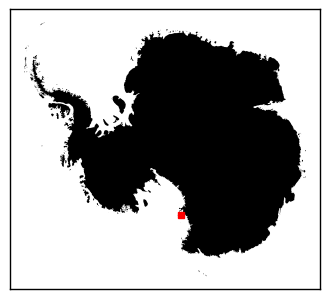

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))

# Erebus inset map
ax.set_aspect(1)
ax.set_facecolor("white")
ax.grid(False)
ax.tick_params(axis="both", bottom=False, labelbottom=False, left=False, labelleft=False, right=False, top=False)
for border in antarc_border:
    bx, by = zip(*border)
    ax.fill(bx, by, "k-", linewidth=0.5)

ax.plot([304107], [-1325761], "rs", markersize=5)

fig.savefig("figs/png/erebus_map.png", dpi=300, bbox_inches="tight")

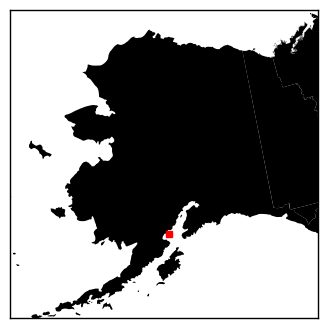

In [19]:
# Alaska inset map
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.set_aspect(1)
ax.set_facecolor("white")
ax.grid(False)
ax.tick_params(axis="both", bottom=False, labelbottom=False, left=False, labelleft=False, right=False, top=False)
for border in alaska_border:
    bx, by = zip(*border)
    ax.fill(bx, by, "k-", linewidth=0.5)

ax.plot([30181], [1042301], "rs", markersize=5)
ax.set_xlim(-1e6, 1e6)
ax.set_ylim(0.5e6, 2.5e6)

fig.savefig("figs/png/augustine_map.png", dpi=300, bbox_inches="tight")